In [ ]:
# -*- coding: utf-8 -*-
%matplotlib inline
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn import metrics
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score



from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.decomposition import PCA

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from scipy import stats

pd.set_option('display.max_columns', 30)

import warnings
warnings.filterwarnings("ignore")

## Chargement et affichage du dataset 

In [ ]:
data = pd.read_csv('data.csv', header = 0) #charger le fichier CSV (dataset) en tant que Dataframe

In [ ]:
data.head() #afficher les 5 premières lignes (observations) du dataframe

,Unnamed: 0,index,date,cheveux,age,exp,salaire,sexe,diplome,specialite,note,dispo,embauche
0,0,0,2012-06-02,roux,25.0,9.0,26803.0,F,licence,geologie,97.08,non,0
1,1,1,2011-04-21,blond,35.0,13.0,38166.0,M,licence,forage,63.86,non,0
2,2,2,2012-09-07,blond,29.0,13.0,35207.0,M,licence,geologie,78.50,non,0
3,3,3,2011-07-01,brun,NaN,12.0,32442.0,M,licence,geologie,45.09,non,0
4,4,4,2012-08-07,roux,35.0,6.0,28533.0,F,licence,detective,81.91,non,0


In [ ]:
print("Nombre d’observations : ", len(data)) #afficher la taille du dataframe (nombre de lignes)

Nombre d’observations :  20000


# 1. Prétraitement de données & Statistiques descriptives

## 1.1 Reformataion des données 
#### consiste à changer la structure de l'ensemble de données en supprimant des colonnes redondantes ou non pertinentes pour le modèle. Le but est de conserver uniquement les colonnes qui apportent de l'information utile pour la prédiction de la classe, et d'éliminer celles qui pourraient nuire au modèle ou n'ont pas d'influence sur la prédiction.

In [ ]:
data = data.drop(['Unnamed: 0', 'index', 'date'], axis=1) #Suppression des variables redondantes (index et Unnamed) et non pertinentes pour la prédiction (date).

In [ ]:
data.head() #reafficher les 5 premières lignes du dataframe après la suppression des 3 variables (Unnamed: 0, index, date)

,cheveux,age,exp,salaire,sexe,diplome,specialite,note,dispo,embauche
0,roux,25.0,9.0,26803.0,F,licence,geologie,97.08,non,0
1,blond,35.0,13.0,38166.0,M,licence,forage,63.86,non,0
2,blond,29.0,13.0,35207.0,M,licence,geologie,78.50,non,0
3,brun,NaN,12.0,32442.0,M,licence,geologie,45.09,non,0
4,roux,35.0,6.0,28533.0,F,licence,detective,81.91,non,0


In [ ]:
data.describe() #affiche le sommaire statistique du dataframe pour les données quantitatives (numériques)

# Count : Compte le nombre d’observation de chaque colonne --> data.count()
# Mean  : Renvoie la moyenne de chaque colonne --> data.mean()                 PS : valeur centrale de la distribution des données
# Std   : Renvoie l'écart-type de chaque colonne --> data.std()                PS:  mesure de la dispersion des données autour de la moyenne, plus l'écart-type est élevé, plus les données sont dispersées
# Min   : Renvoie la valeur minimale de chaque colonne --> data.min()
# 25%   : Renvoie le premier quantile Q1 de chaque colonne --> data["age"].quantile(0.25)
# 50%   : Renvoie la mediane de chaque colonne  --> data.median() ou data["age"].quantile(0.50)
# 75%   : Renvoie le troisième quantile Q3 de chaque colonne --> data["age"].quantile(0.75)
# Max   : Renvoie la valeur maximale de chaque colonne --> data.max()

,age,exp,salaire,note,embauche
count,19909.000000,19904.000000,19905.000000,19886.000000,20000.000000
mean,35.004521,9.500352,34974.343934,75.168762,0.114600
std,9.609169,3.012109,5003.099616,17.095926,0.318547
min,-3.000000,-2.000000,14128.000000,8.680000,0.000000
25%,29.000000,7.000000,31596.000000,63.720000,0.000000
50%,35.000000,9.000000,34979.000000,75.080000,0.000000
75%,41.000000,12.000000,38358.000000,86.617500,0.000000
max,74.000000,23.000000,53977.000000,143.220000,1.000000


In [ ]:
data.corr() #Renvoie une matrice de corrélation entre chaque 2 variables quantitatives. PS : Plus la valeur se rapproche de 1, plus la corrélation est forte.

,age,exp,salaire,note,embauche
age,1.000000,-0.002786,0.001161,-0.007534,-0.011623
exp,-0.002786,1.000000,0.009709,-0.012195,0.006604
salaire,0.001161,0.009709,1.000000,-0.448422,0.002342
note,-0.007534,-0.012195,-0.448422,1.000000,0.003019
embauche,-0.011623,0.006604,0.002342,0.003019,1.000000


## 1.2 Nettoyages des données
#### Le nettoyage de données inclurt des opérations telles que la la gestion des valeurs manquantes, la suppression de doublons, et la gestion des valeurs aberrantes.  

### 1.2.1 Gestion des valeurs manquantes
#### Les valeurs manquantes sont des valeurs absentes dans le jeu de données, généralement représentées par "NaN" ou "NULL". Les valeurs manquantes peuvent affecter les résultats d'un modèle de machine learning, car elles peuvent influencer les statistiques et les corrélations entre les variables. 
#### Cette étape implique la détermination de la façon de gérer ces valeurs manquantes, par exemple suppression de la ligne ou utilisation de la moyenne ou la médiane de la colonne correspondante...

In [ ]:
data.isnull().values.any() #Le dataset contient des valeurs manquantes (NaN)

True

In [ ]:
data.iloc[2251:2252] #Exemple du dataframe (ligne ayant 2 valaeurs manquantes NAN pour l'age et l'experience)

,cheveux,age,exp,salaire,sexe,diplome,specialite,note,dispo,embauche
2251,brun,NaN,NaN,35573.0,F,licence,forage,71.51,non,0


In [ ]:
print("Nombre de valeurs non manquantes pour chaque variable : ") 
data.count()                                     

Nombre de valeurs non manquantes pour chaque variable : 


cheveux       19897
age           19909
exp           19904
salaire       19905
sexe          19900
diplome       19890
specialite    19907
note          19886
dispo         19894
embauche      20000
dtype: int64

Le nombre de valeurs non manquantes pour toutes les variables est inférieur strictement au nombre total d'observations (20000), sauf pour la variable de prédiction "embauche" 
Donc on confirme qu'il existe des valeurs manquantes dans le dataset   

on calcule maintenant le nombre de valeurs manquantes pour chaque variable (calcul complémentaire du calcul précédent)

In [ ]:
print("Nombre de valeurs manquantes pour chaque variable : ") 
data.isnull().sum()  

# cheveux    : 19897 + 103 = 20000 
# age        : 19909 + 91  = 20000 
# exp        : 19904 + 96  = 20000 
# salaire    : 19905 + 95  = 20000 
# sexe       : 19900 + 100 = 20000 
# diplome    : 19890 + 110 = 20000 
# specialite : 19907 + 93  = 20000 
# note       : 19886 + 114 = 20000 
# dispo      : 19894 + 106 = 20000 
# embauche   : 20000 + 0   = 20000 

Nombre de valeurs manquantes pour chaque variable : 


cheveux       103
age            91
exp            96
salaire        95
sexe          100
diplome       110
specialite     93
note          114
dispo         106
embauche        0
dtype: int64

calculons pour chauqe variable, la proportion du nombre des valeurs manquantes par rapport au nombre total des valeurs 

In [ ]:
missing_df = data.isnull().sum(axis=0).reset_index()
missing_df.columns = ['Variable', 'Valeurs Manqauntes']
missing_df['Proportion'] = round((missing_df['Valeurs Manqauntes'] / data.shape[0])*100).astype(int).astype(str) + '%'
missing_df

,Variable,Valeurs Manqauntes,Proportion
0,cheveux,103,1%
1,age,91,0%
2,exp,96,0%
3,salaire,95,0%
4,sexe,100,0%
5,diplome,110,1%
6,specialite,93,0%
7,note,114,1%
8,dispo,106,1%
9,embauche,0,0%


Les valeurs manquantes représentent entre 0% et 1% de leur variable correspondante. On pourra donc les supprimer sans affecter les données.

In [ ]:
data.dropna(inplace=True)

Revérifions si le dataset ne contient plus de valeurs manquantes

In [ ]:
print(data.isnull().values.any()) #Le dataset ne contient plus de valeurs manquantes (NaN)
print("")

print("Nombre de valeurs manquantes pour chaque variable : ") 
print(data.isnull().sum())
print("")

print("Nombre de valeurs non manquantes pour chaque variable : ") 
print(data.count())  
print("")

False

Nombre de valeurs manquantes pour chaque variable : 
cheveux       0
age           0
exp           0
salaire       0
sexe          0
diplome       0
specialite    0
note          0
dispo         0
embauche      0
dtype: int64

Nombre de valeurs non manquantes pour chaque variable : 
cheveux       19109
age           19109
exp           19109
salaire       19109
sexe          19109
diplome       19109
specialite    19109
note          19109
dispo         19109
embauche      19109
dtype: int64



In [ ]:
 print("Nombre d’observations aprés la suppression des valeurs manquantes : ", len(data)) #afficher la nouvelle taille du dataframe (nombre de lignes)

Nombre d’observations aprés la suppression des valeurs manquantes :  19109


On a supprimé en tout (2OOOO - 19109 = 891) lignes de notre dataset initial

### 1.2.2 Suppression de doublons
#### Les doublons sont des entrées (lignes) en double dans le jeu de données. Les doublons peuvent perturber les résultats d'un modèle de machine learning en augmentant la taille du jeu de données sans apporter de nouvelles informations.
#### Cette étape implique la suppression de ces doublons.

In [ ]:
data.drop_duplicates(inplace = True)

print("Nombre d’observations aprés la suppression des doublons : ", len(data))

Nombre d’observations aprés la suppression des doublons :  19109


Le nombre d’observations n'a pas diminué après la suppression des doublons, et donc il n'y a pas de doublons dans le dataset.


### 1.2.3 Gestion des valeurs aberrantes (Outliers)
#### Les valeurs aberrantes sont des valeurs très éloignées de la distribution normale des données, ce qui peut affecter les résultats des modèles de machine learning. 
#### Cette étape implique la détermination de la façon de gérer ces valeurs aberrantes, par exemple suppression, correction... 



In [ ]:
#data.drop(['embauche'], axis=1).plot(kind='box', figsize=(18, 16), subplots=True, layout=(4,2), sharex=False, sharey=False, title='Attributes Box Plots')
#plt.show()

In [ ]:
data = data.loc[((data['note'] >= 0) & (data['note'] <= 100)) & ((data['age'] >= 18) & (data['age'] <= 65)) & (data['exp'] >= 0) & (data['salaire'] >= 0)]

In [ ]:
Q1 = data['age'].describe()['25%']
Q3 = data['age'].describe()['75%']

iqr = Q3 - Q1
Max = Q3 + 1.5 * iqr
Min = Q1 - 1.5 * iqr

data = data[(data['age'] > Min) & (data['age'] < Max)]

In [ ]:
Q1 = data['exp'].describe()['25%']
Q3 = data['exp'].describe()['75%']

iqr = Q3 - Q1
Min = Q3 + 1.5 * iqr
Max = Q1 - 1.5 * iqr

data = data[(data['exp'] > Min) & (data['exp'] < Max)]

In [ ]:
Q1 = data['salaire'].describe()['25%']
Q3 = data['salaire'].describe()['75%']

iqr = Q3 - Q1
Max = Q3 + 1.5 * iqr
Min = Q1 - 1.5 * iqr

data = data[(data['salaire'] > Min) & (data['salaire'] < Max)]

In [ ]:
Q1 = data['note'].describe()['25%']
Q3 = data['note'].describe()['75%']

iqr = Q3 - Q1
Min = Q3 + 1.5 * iqr
Max = Q1 - 1.5 * iqr

data = data[(data['note'] > Min) & (data['note'] < Max)]

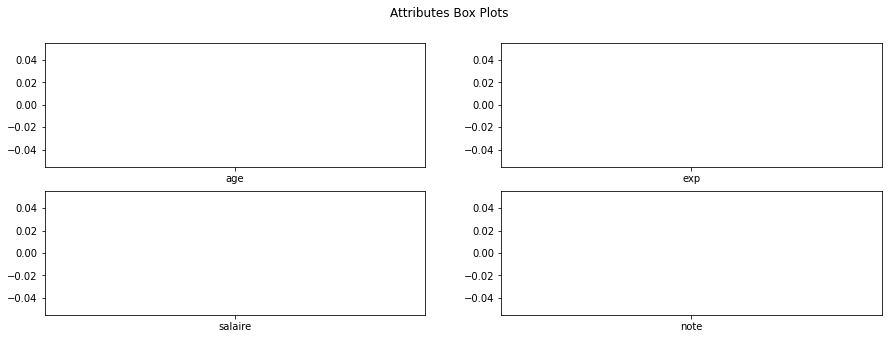

In [ ]:
data.drop(['embauche'], axis=1).plot(kind='box', figsize=(15, 5), subplots=True, layout=(2,2), sharex=False, sharey=False, title='Attributes Box Plots')
plt.show()

In [ ]:
#Nombre d'outliers pour la variable age
df = data["age"]
df = df.to_frame() #
age_outliers = df[(df['age'] < 18) | (df['age'] > 65)]
num_age_outliers = age_outliers["age"].count()
print("Le nombre d'outliers dans la colonne 'âge' est:", num_age_outliers)

#Nombre d'outliers pour la variable exp
df = data["exp"]
df = df.to_frame() #
age_outliers = df[(df['exp'] < 0)]
num_age_outliers = age_outliers["exp"].count()
print("Le nombre d'outliers dans la colonne 'exp' est:", num_age_outliers)

#Nombre d'outliers pour la variable salaire
df = data["salaire"]
df = df.to_frame() #
age_outliers = df[(df['salaire'] < 0)]
num_age_outliers = age_outliers["salaire"].count()
print("Le nombre d'outliers dans la colonne 'salaire' est:", num_age_outliers)

#Nombre d'outliers pour la variable note
df = data["note"]
df = df.to_frame() #
age_outliers = df[(df['note'] < 0) | (df['note'] > 100)]
num_age_outliers = age_outliers["note"].count()
print("Le nombre d'outliers dans la colonne 'note' est:", num_age_outliers)

Le nombre d'outliers dans la colonne 'âge' est: 0
Le nombre d'outliers dans la colonne 'exp' est: 0
Le nombre d'outliers dans la colonne 'salaire' est: 0
Le nombre d'outliers dans la colonne 'note' est: 0


In [ ]:
#Nombre d'outliers pour la variable age
df = data["age"]
df = df.to_frame() #
age_outliers = df[(df['age'] < 18) | (df['age'] > 65)]
num_age_outliers = age_outliers["age"].count()
print("Le nombre d'outliers dans la colonne 'âge' est:", num_age_outliers)

#Nombre d'outliers pour la variable exp
df = data["exp"]
df = df.to_frame() #
age_outliers = df[(df['exp'] < 0)]
num_age_outliers = age_outliers["exp"].count()
print("Le nombre d'outliers dans la colonne 'exp' est:", num_age_outliers)

#Nombre d'outliers pour la variable salaire
df = data["salaire"]
df = df.to_frame() #
age_outliers = df[(df['salaire'] < 0)]
num_age_outliers = age_outliers["salaire"].count()
print("Le nombre d'outliers dans la colonne 'salaire' est:", num_age_outliers)

#Nombre d'outliers pour la variable note
df = data["note"]
df = df.to_frame() #
age_outliers = df[(df['note'] < 0) | (df['note'] > 100)]
num_age_outliers = age_outliers["note"].count()
print("Le nombre d'outliers dans la colonne 'note' est:", num_age_outliers)

Le nombre d'outliers dans la colonne 'âge' est: 0
Le nombre d'outliers dans la colonne 'exp' est: 0
Le nombre d'outliers dans la colonne 'salaire' est: 0
Le nombre d'outliers dans la colonne 'note' est: 0
